In [ ]:
# Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
plt.rcParams['figure.figsize'] = [10, 8]
import warnings
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# -----------------------------------------------
# Load and Prepare JJ Dataset
# -----------------------------------------------
jj_df = pd.read_csv('/content/drive/MyDrive/jj.csv')
jj_df.columns = ['date', 'value']
jj_df['date'] = pd.to_datetime(jj_df['date'])
jj_df.set_index('date', inplace=True)

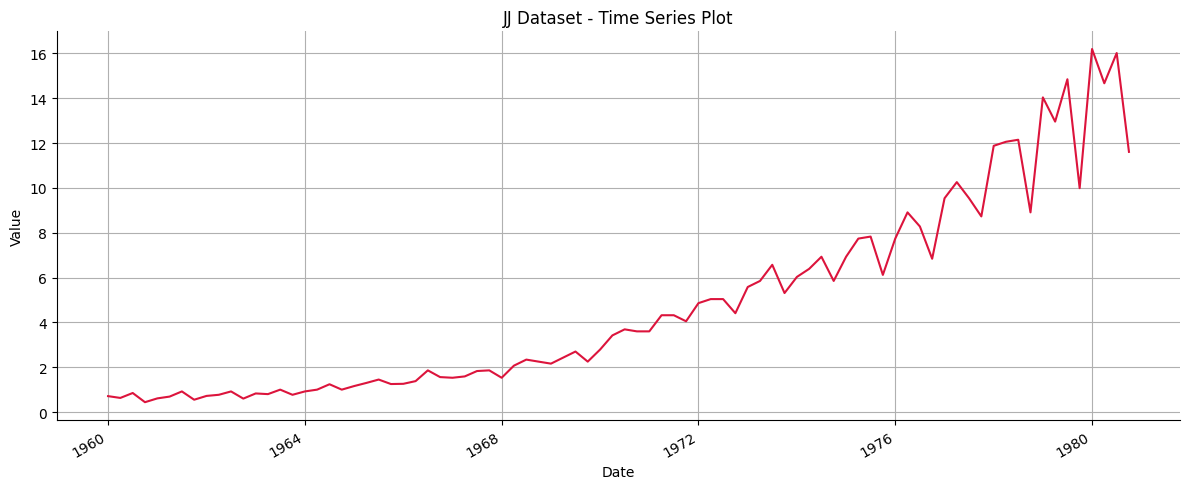

In [ ]:
# Line plot of the JJ dataset using 'value' column and custom color
jj_df['value'].plot(
    kind='line',
    title='JJ Dataset - Time Series Plot',
    color='crimson',
    figsize=(12, 5)
)
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

In [ ]:
jj_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 1960-01-01 to 1980-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   84 non-null     float64
dtypes: float64(1)
memory usage: 1.3 KB


**Check For Non-Stationary**

In [ ]:
# Perform ADF test on the original (non-differenced) series
adf_lvl = adfuller(jj_df['value'].dropna())
print("ADF Test p-value (Level):", adf_lvl[1])

# Perform ADF test after first-order differencing
adf_1st_diff = adfuller(jj_df['value'].diff().dropna())
print("ADF Test p-value (1st Difference):", adf_1st_diff[1])

# Perform ADF test after second-order differencing
adf_2nd_diff = adfuller(jj_df['value'].diff().diff().dropna())
print("ADF Test p-value (2nd Difference):", adf_2nd_diff[1])

ADF Test p-value (Level): 1.0
ADF Test p-value (1st Difference): 0.9088542416911305
ADF Test p-value (2nd Difference): 0.006051099869603682


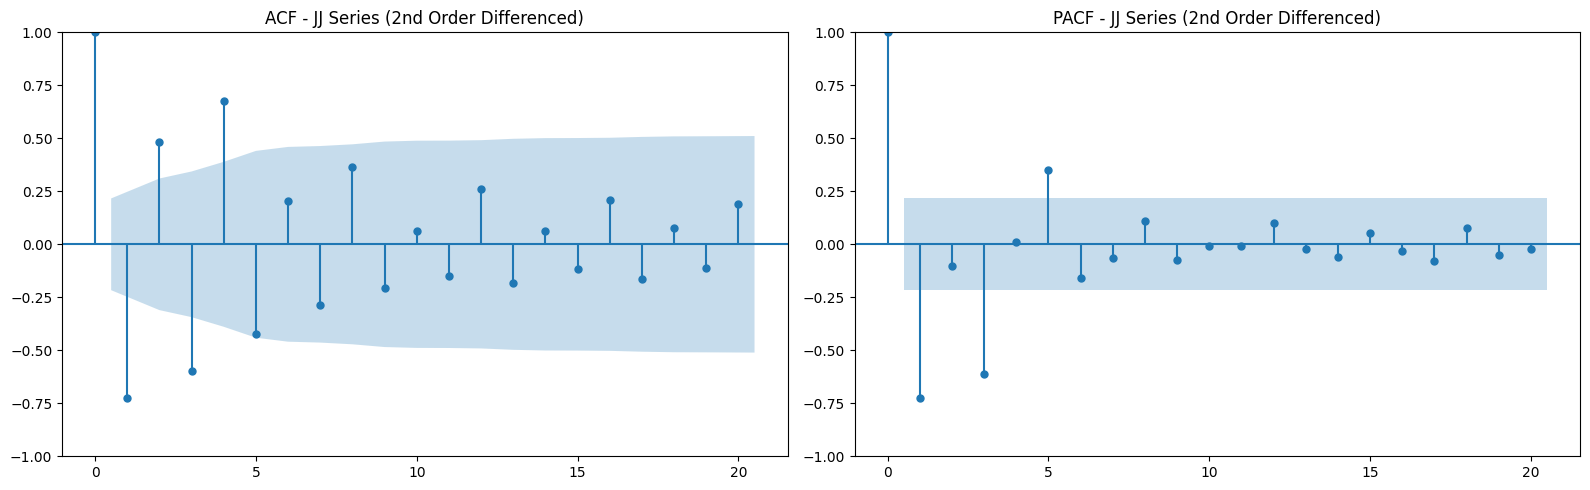

In [ ]:
# Perform second-order differencing to stabilize the JJ time series
diff_data = jj_df['value'].diff().dropna().diff().dropna()
# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(diff_data, lags=20, ax=axes[0])
axes[0].set_title("ACF - JJ Series (2nd Order Differenced)")
plot_pacf(diff_data, lags=20, ax=axes[1])
axes[1].set_title("PACF - JJ Series (2nd Order Differenced)")
plt.tight_layout()
plt.show()


In [ ]:
# -----------------------------
# Grid Search to Find Best ARIMA(p, 2, q) Based on AIC
# -----------------------------

lowest_aic = float("inf")
best_order = None
best_model = None

# Try combinations of (p, d=2, q) for p and q in [0, 3]
for p in range(4):
    for q in range(4):
        try:
            model = ARIMA(jj_df['value'], order=(p, 2, q)).fit()
            if model.aic < lowest_aic:
                lowest_aic = model.aic
                best_order = (p, 2, q)
                best_model = model
        except:
            continue  # Skip combinations that result in errors

print("Best ARIMA Order (p, d=2, q):", best_order)


Best ARIMA Order (p, d=2, q): (3, 2, 3)


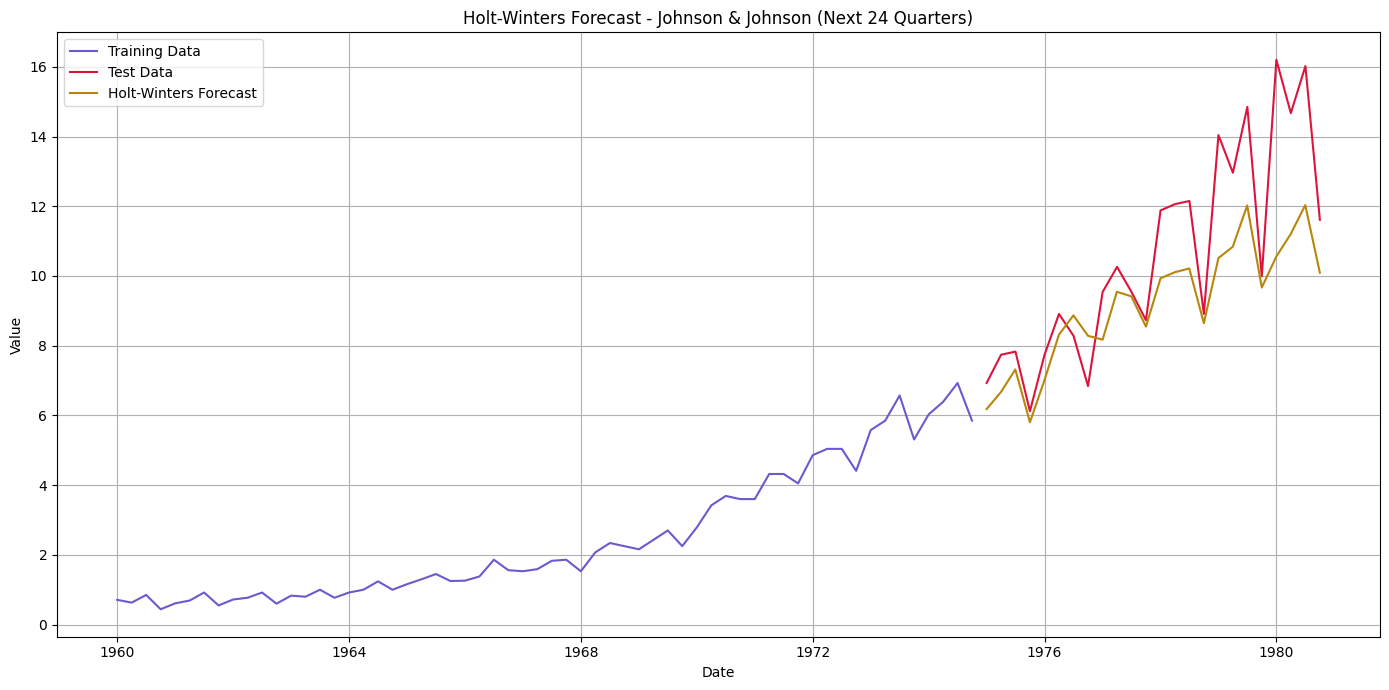

MAE  : 1.5787
MSE  : 4.4277
RMSE : 2.1042


In [ ]:
# 1. Copy the original dataset
jj_smooth = jj_df.copy()

# 2. Apply smoothing techniques (optional)
jj_smooth['6Q-SMA'] = jj_smooth['value'].rolling(window=6).mean()
jj_smooth['12Q-SMA'] = jj_smooth['value'].rolling(window=12).mean()
jj_smooth['EWMA-12'] = jj_smooth['value'].ewm(span=12, adjust=False).mean()

# 3. Split the data into training and testing sets
test_size = 24
train_data = jj_smooth[:-test_size]
test_data = jj_smooth[-test_size:]

# 4. Fit Holt-Winters Exponential Smoothing model
hw_model = ExponentialSmoothing(
    train_data['value'],
    trend='add',
    seasonal='mul',
    seasonal_periods=24
)
hw_fitted = hw_model.fit()

# 5. Generate forecast for the next 24 quarters
forecast_horizon = 24
forecast_dates = pd.date_range(
    start=train_data.index[-1] + pd.DateOffset(months=3),
    periods=forecast_horizon,
    freq='QS'
)
hw_forecast = hw_fitted.forecast(forecast_horizon)
hw_forecast_series = pd.Series(hw_forecast.values, index=forecast_dates, name='Forecast')

# 6. Plot training, testing, and forecast results
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['value'], label='Training Data', color='slateblue')
plt.plot(test_data.index, test_data['value'], label='Test Data', color='crimson')
plt.plot(hw_forecast_series.index, hw_forecast_series, label='Holt-Winters Forecast', color='darkgoldenrod')
plt.title("Holt-Winters Forecast - Johnson & Johnson (Next 24 Quarters)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Evaluate forecast accuracy against test data
hw_eval = hw_forecast_series[:len(test_data)]
mae = mean_absolute_error(test_data['value'], hw_eval)
mse = mean_squared_error(test_data['value'], hw_eval)
rmse = np.sqrt(mse)

print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")


**Build an RNN based model (LSTM, GRU)**

Epoch 1/50
8/8 - 5s - 681ms/step - loss: 0.1083 - val_loss: 0.4113
Epoch 2/50
8/8 - 1s - 70ms/step - loss: 0.0645 - val_loss: 0.2218
Epoch 3/50
8/8 - 0s - 27ms/step - loss: 0.0781 - val_loss: 0.1695
Epoch 4/50
8/8 - 1s - 101ms/step - loss: 0.0626 - val_loss: 0.1705
Epoch 5/50
8/8 - 0s - 62ms/step - loss: 0.0425 - val_loss: 0.1002
Epoch 6/50
8/8 - 0s - 54ms/step - loss: 0.0312 - val_loss: 0.1229
Epoch 7/50
8/8 - 0s - 29ms/step - loss: 0.0380 - val_loss: 0.0982
Epoch 8/50
8/8 - 0s - 17ms/step - loss: 0.0272 - val_loss: 0.1028
Epoch 9/50
8/8 - 0s - 16ms/step - loss: 0.0291 - val_loss: 0.1023
Epoch 10/50
8/8 - 0s - 18ms/step - loss: 0.0294 - val_loss: 0.0978
Epoch 11/50
8/8 - 0s - 18ms/step - loss: 0.0300 - val_loss: 0.1009
Epoch 12/50
8/8 - 0s - 17ms/step - loss: 0.0346 - val_loss: 0.0965
Epoch 13/50
8/8 - 0s - 17ms/step - loss: 0.0283 - val_loss: 0.0956
Epoch 14/50
8/8 - 0s - 19ms/step - loss: 0.0295 - val_loss: 0.1136
Epoch 15/50
8/8 - 0s - 17ms/step - loss: 0.0331 - val_loss: 0.0960
Ep

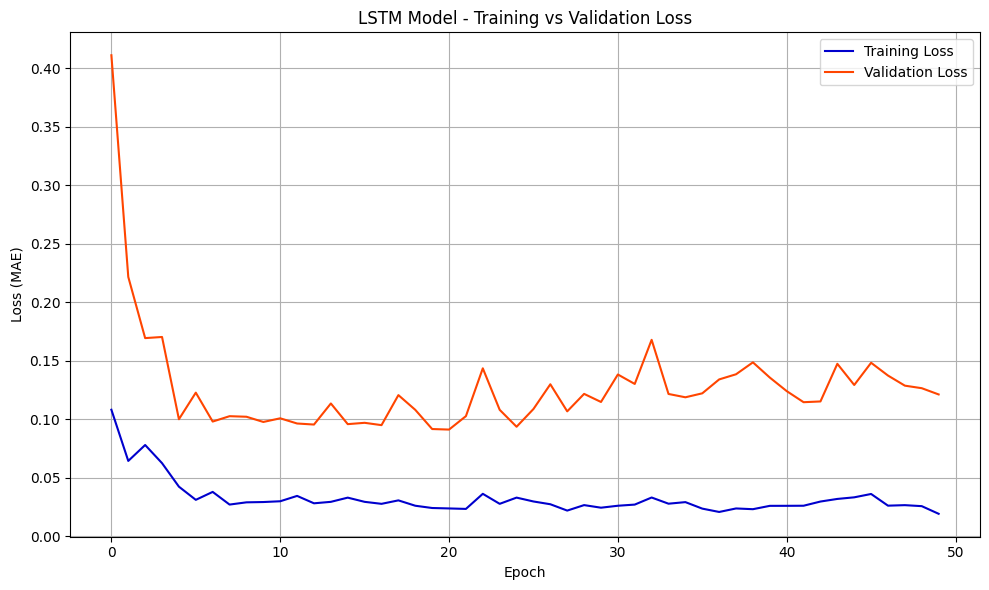

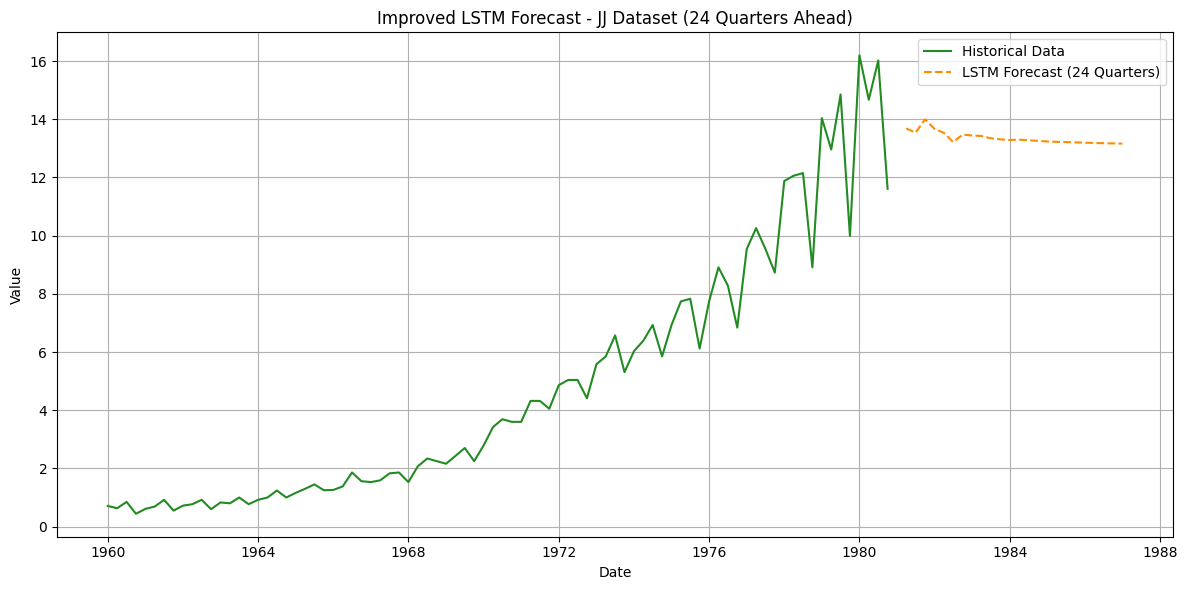

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
LSTM Model Evaluation Metrics:
MAE  : 1.9125
MSE  : 4.3778
RMSE : 2.0923
R²   : 0.2518


In [ ]:
from pandas import DataFrame, concat
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# -------------------------------------------------
# Load and Normalize JJ Dataset
# -------------------------------------------------
jj_df = pd.read_csv('/content/drive/MyDrive/jj.csv')
jj_df.columns = ['date', 'value']
jj_df['date'] = pd.to_datetime(jj_df['date'])
jj_df.set_index('date', inplace=True)

# Normalize the 'value' column
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(jj_df[['value']].values.astype('float32'))

# -------------------------------------------------
# Convert Time Series to Supervised Format
# -------------------------------------------------
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = DataFrame(data)
    cols, names = [], []

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'var{j+1}(t-{i})' for j in range(n_vars)]

    for i in range(0, n_out):
        cols.append(df.shift(-i))
        names += [f'var{j+1}(t+{i})' for j in range(n_vars)]

    agg = concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)

    return agg

# Use 6 past time steps
supervised_df = series_to_supervised(scaled_values, n_in=6, n_out=1)

# -------------------------------------------------
# Prepare Training and Testing Data
# -------------------------------------------------
X_all = supervised_df.iloc[:, :-1]
y_all = supervised_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=False)

X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

# -------------------------------------------------
# Build and Train LSTM Model
# -------------------------------------------------
lstm_model = Sequential()
lstm_model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(32))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mae', optimizer='adam')

history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_test, y_test),
    verbose=2,
    shuffle=False
)

# -------------------------------------------------
# Plot Training History
# -------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='mediumblue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orangered')
plt.title('LSTM Model - Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Forecast 24 Future Quarters
# -------------------------------------------------
last_input = scaled_values[-6:]
future_preds = []

for _ in range(24):
    seq_input = last_input.reshape((1, 6, 1))
    next_pred = lstm_model.predict(seq_input, verbose=0)[0][0]
    future_preds.append(next_pred)
    last_input = np.append(last_input[1:], [[next_pred]], axis=0)

# Inverse scale predictions
future_forecast = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# Create future date range
last_known_date = jj_df.index[-1]
future_dates = pd.date_range(start=last_known_date + pd.DateOffset(months=3), periods=24, freq='Q')
future_df = pd.DataFrame(future_forecast, index=future_dates, columns=['Forecast'])

# -------------------------------------------------
# Plot Forecast
# -------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(jj_df.index, jj_df['value'], label='Historical Data', color='forestgreen')
plt.plot(future_df.index, future_df['Forecast'], label='LSTM Forecast (24 Quarters)', color='darkorange', linestyle='--')
plt.title('Improved LSTM Forecast - JJ Dataset (24 Quarters Ahead)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Evaluate Model on Test Data
# -------------------------------------------------
y_pred_scaled = lstm_model.predict(X_test)
y_pred_actual = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.values.reshape(-1, 1))

mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred_actual)

print("LSTM Model Evaluation Metrics:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0380 - val_loss: 0.1438
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0054 - val_loss: 0.0172
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0075 - val_loss: 0.0372
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0031 - val_loss: 0.0328
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0016 - val_loss: 0.0172
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0010 - val_loss: 0.0172
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0011 - val_loss: 0.0194
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


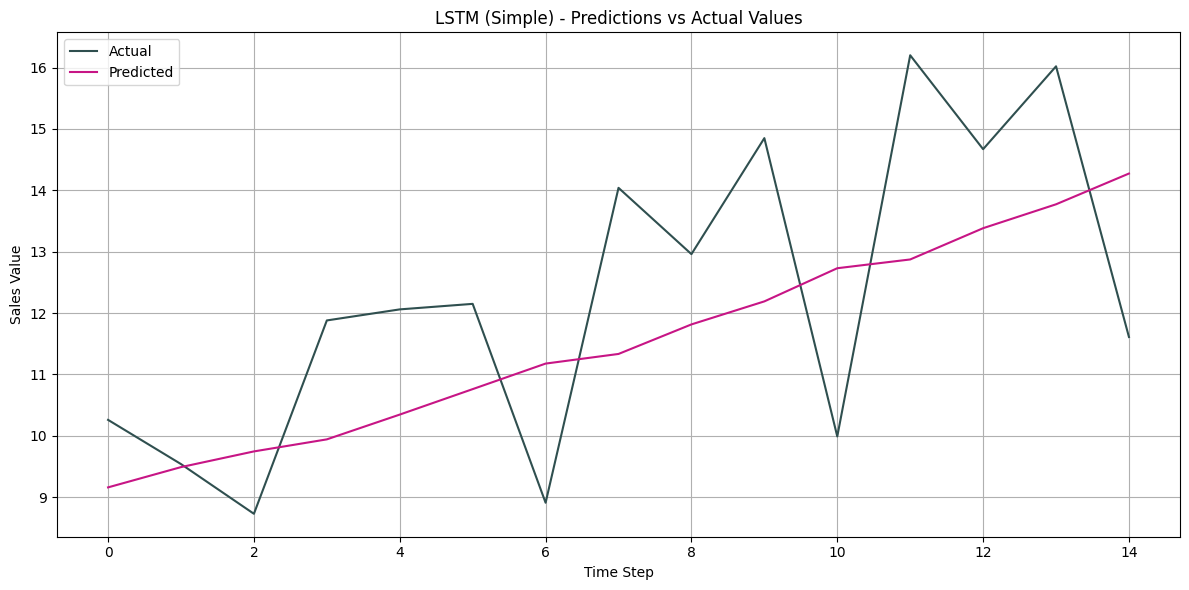

In [ ]:
# -------------------------------------------------
# Normalize the JJ Dataset for LSTM
# -------------------------------------------------
scaler = MinMaxScaler()
jj_df[['value']] = scaler.fit_transform(jj_df[['value']])

# -------------------------------------------------
# Create Sequences for Time Series Supervision
# -------------------------------------------------
def create_sequences(data_series, seq_length):
    X, y = [], []
    for i in range(len(data_series) - seq_length):
        X.append(data_series[i:i+seq_length])
        y.append(data_series[i+seq_length])
    return np.array(X), np.array(y)

sequence_len = 12
X, y = create_sequences(jj_df['value'].values, sequence_len)
X = X.reshape((X.shape[0], X.shape[1], 1))

# -------------------------------------------------
# Split into Train and Test Sets
# -------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# -------------------------------------------------
# Define and Train LSTM Model
# -------------------------------------------------
lstm_model_simple = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])
lstm_model_simple.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lstm_model_simple.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=8,
    callbacks=[early_stopping],
    verbose=1
)

# -------------------------------------------------
# Plot Predictions vs Actual Values (Updated Colors)
# -------------------------------------------------
def plot_predictions(model, X_test, y_test, model_name="Model"):
    """
    Plot predicted values vs actual values for a given model.

    Parameters:
        model (keras.Model): Trained model
        X_test (array): Test input features
        y_test (array): Actual target values (scaled)
        model_name (str): Name to display in the plot title
    """
    predictions = model.predict(X_test)

    # Plotting actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual', color='darkslategray')
    plt.plot(scaler.inverse_transform(predictions), label='Predicted', color='mediumvioletred')
    plt.title(f"{model_name} - Predictions vs Actual Values")
    plt.xlabel("Time Step")
    plt.ylabel("Sales Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# -------------------------------------------------
# Visualize Prediction Results
# -------------------------------------------------
plot_predictions(lstm_model_simple, X_test, y_test, "LSTM (Simple)")

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# -----------------------------------------------
# Predict on the Test Set
# -----------------------------------------------
lstm_predictions_scaled = lstm_model_simple.predict(X_test)

# Inverse scaling to original scale
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_actual = scaler.inverse_transform(lstm_predictions_scaled).flatten()

# -----------------------------------------------
# Calculate Evaluation Metrics
# -----------------------------------------------
mae_lstm = mean_absolute_error(y_test_actual, y_pred_actual)
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mape_lstm = mean_absolute_percentage_error(y_test_actual, y_pred_actual)

# -----------------------------------------------
# Output Model Performance
# -----------------------------------------------
print("LSTM Model Evaluation Metrics:")
print(f"MAE  : {mae_lstm:.4f}")
print(f"RMSE : {rmse_lstm:.4f}")
print(f"MAPE : {mape_lstm:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
LSTM Model Evaluation Metrics:
MAE  : 1.8832
RMSE : 2.0670
MAPE : 0.1533


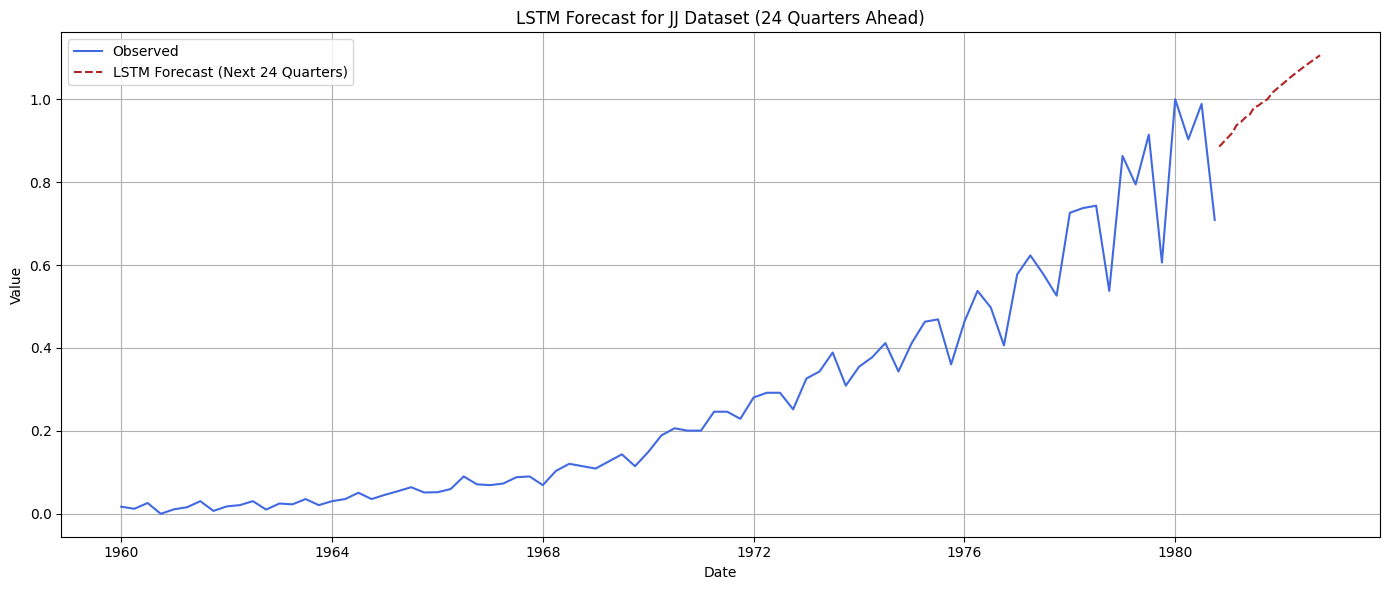

In [ ]:
# -----------------------------------------------
# Forecasting Function for Future Values
# -----------------------------------------------
def forecast_future(model, scaled_data, scaler, n_future=24, seq_len=12):
    last_seq = scaled_data[-seq_len:].reshape(1, seq_len, 1)
    forecast = []

    for _ in range(n_future):
        next_pred = model.predict(last_seq, verbose=0)[0][0]
        forecast.append(next_pred)
        last_seq = np.append(last_seq[:, 1:, :], [[[next_pred]]], axis=1)

    return scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# -----------------------------------------------
# Prepare Scaled Data for Forecasting
# -----------------------------------------------
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(jj_df['value'].values.reshape(-1, 1))

# Forecast the Next 24 Months (Monthly Intervals)
future_forecast = forecast_future(lstm_model_simple, scaled_series, scaler, n_future=24, seq_len=12)

# Generate future date range (Monthly frequency)
forecast_start = jj_df.index[-1] + pd.DateOffset(months=1)
future_dates = pd.date_range(start=forecast_start, periods=24, freq='MS')

# -----------------------------------------------
# Plot Observed vs Forecasted Data (Updated Colors)
# -----------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(jj_df.index, scaler.inverse_transform(scaled_values), label='Observed', color='royalblue')
plt.plot(future_dates, future_forecast, label='LSTM Forecast (Next 24 Quarters)', color='firebrick', linestyle='--')
plt.title('LSTM Forecast for JJ Dataset (24 Quarters Ahead)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
